In [1]:
#from models.conformer import ConformerBlock
import torch
import matplotlib.pyplot as plt
#import torch.nn as nn
from tqdm import tqdm
#import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.distributions import Normal

from einops import rearrange
from einops.layers.torch import Rearrange

# source: https://github.com/lucidrains/conformer/blob/master/conformer/conformer.py
# helper functions


def exists(val):
    return val is not None


def default(val, d):
    return val if exists(val) else d


def calc_same_padding(kernel_size):
    pad = kernel_size // 2
    return (pad, pad - (kernel_size + 1) % 2)


class Swish(nn.Module):
    def forward(self, x):
        return x * x.sigmoid()


class GLU(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        out, gate = x.chunk(2, dim=self.dim)
        return out * gate.sigmoid()


class DepthWiseConv1d(nn.Module):
    def __init__(self, chan_in, chan_out, kernel_size, padding):
        super().__init__()
        self.padding = padding
        self.conv = nn.Conv1d(chan_in, chan_out, kernel_size, groups=chan_in)

    def forward(self, x):
        x = F.pad(x, self.padding)
        return self.conv(x)


# attention, feedforward, and conv module


class Scale(nn.Module):
    def __init__(self, scale, fn):
        super().__init__()
        self.fn = fn
        self.scale = scale

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) * self.scale


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, **kwargs):
        x = self.norm(x)
        return self.fn(x, **kwargs)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0, max_pos_emb=512):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head**-0.5
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

        self.max_pos_emb = max_pos_emb
        self.rel_pos_emb = nn.Embedding(2 * max_pos_emb + 1, dim_head)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, context=None, mask=None, context_mask=None):
        n, device, h, max_pos_emb, has_context = (
            x.shape[-2],
            x.device,
            self.heads,
            self.max_pos_emb,
            exists(context),
        )
        context = default(context, x)

        q, k, v = (self.to_q(x), *self.to_kv(context).chunk(2, dim=-1))
        q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=h), (q, k, v))

        dots = einsum("b h i d, b h j d -> b h i j", q, k) * self.scale

        # shaw's relative positional embedding
        seq = torch.arange(n, device=device)
        dist = rearrange(seq, "i -> i ()") - rearrange(seq, "j -> () j")
        dist = dist.clamp(-max_pos_emb, max_pos_emb) + max_pos_emb
        rel_pos_emb = self.rel_pos_emb(dist).to(q)
        pos_attn = einsum("b h n d, n r d -> b h n r", q, rel_pos_emb) * self.scale
        dots = dots + pos_attn

        if exists(mask) or exists(context_mask):
            mask = default(mask, lambda: torch.ones(*x.shape[:2], device=device))
            context_mask = (
                default(context_mask, mask)
                if not has_context
                else default(
                    context_mask, lambda: torch.ones(*context.shape[:2], device=device)
                )
            )
            mask_value = -torch.finfo(dots.dtype).max
            mask = rearrange(mask, "b i -> b () i ()") * rearrange(
                context_mask, "b j -> b () () j"
            )
            dots.masked_fill_(~mask, mask_value)

        attn = dots.softmax(dim=-1)

        out = einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.to_out(out)
        return self.dropout(out)


class FeedForward(nn.Module):
    def __init__(self, dim, mult=4, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult),
            Swish(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class ConformerConvModule(nn.Module):
    def __init__(
        self, dim, causal=False, expansion_factor=2, kernel_size=31, dropout=0.0
    ):
        super().__init__()

        inner_dim = dim * expansion_factor
        padding = calc_same_padding(kernel_size) if not causal else (kernel_size - 1, 0)

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange("b n c -> b c n"),
            nn.Conv1d(dim, inner_dim * 2, 1),
            GLU(dim=1),
            DepthWiseConv1d(
                inner_dim, inner_dim, kernel_size=kernel_size, padding=padding
            ),
            nn.BatchNorm1d(inner_dim) if not causal else nn.Identity(),
            Swish(),
            nn.Conv1d(inner_dim, dim, 1),
            Rearrange("b c n -> b n c"),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


# Conformer Block


class ConformerBlock(nn.Module):
    def __init__(
        self,
        *,
        dim,
        dim_head=64,
        heads=8,
        ff_mult=4,
        conv_expansion_factor=2,
        conv_kernel_size=31,
        attn_dropout=0.0,
        ff_dropout=0.0,
        conv_dropout=0.0
    ):
        super().__init__()
        self.ff1 = FeedForward(dim=dim, mult=ff_mult, dropout=ff_dropout)
        self.attn = Attention(
            dim=dim, dim_head=dim_head, heads=heads, dropout=attn_dropout
        )
        self.conv = ConformerConvModule(
            dim=dim,
            causal=False,
            expansion_factor=conv_expansion_factor,
            kernel_size=conv_kernel_size,
            dropout=conv_dropout,
        )
        self.ff2 = FeedForward(dim=dim, mult=ff_mult, dropout=ff_dropout)

        self.attn = PreNorm(dim, self.attn)
        self.ff1 = Scale(0.5, PreNorm(dim, self.ff1))
        self.ff2 = Scale(0.5, PreNorm(dim, self.ff2))

        self.post_norm = nn.LayerNorm(dim)

    def forward(self, x, mask=None):
        x = self.ff1(x) + x
        x = self.attn(x, mask=mask) + x
        x = self.conv(x) + x
        x = self.ff2(x) + x
        x = self.post_norm(x)
        return x

class DilatedDenseNet(nn.Module):
    def __init__(self, depth=4, in_channels=64):
        super(DilatedDenseNet, self).__init__()
        self.depth = depth
        self.in_channels = in_channels
        self.pad = nn.ConstantPad2d((1, 1, 1, 0), value=0.0)
        self.twidth = 2
        self.kernel_size = (self.twidth, 3)
        for i in range(self.depth):
            dil = 2**i
            pad_length = self.twidth + (dil - 1) * (self.twidth - 1) - 1
            setattr(
                self,
                "pad{}".format(i + 1),
                nn.ConstantPad2d((1, 1, pad_length, 0), value=0.0),
            )
            setattr(
                self,
                "conv{}".format(i + 1),
                nn.Conv2d(
                    self.in_channels * (i + 1),
                    self.in_channels,
                    kernel_size=self.kernel_size,
                    dilation=(dil, 1),
                ),
            )
            setattr(
                self,
                "norm{}".format(i + 1),
                nn.InstanceNorm2d(in_channels, affine=True),
            )
            setattr(self, "prelu{}".format(i + 1), nn.PReLU(self.in_channels))

    def forward(self, x):
        skip = x
        for i in range(self.depth):
            out = getattr(self, "pad{}".format(i + 1))(skip)
            out = getattr(self, "conv{}".format(i + 1))(out)
            out = getattr(self, "norm{}".format(i + 1))(out)
            out = getattr(self, "prelu{}".format(i + 1))(out)
            skip = torch.cat([out, skip], dim=1)
        return out


class DenseEncoder(nn.Module):
    def __init__(self, in_channel, channels=64):
        super(DenseEncoder, self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channel, channels, (1, 1), (1, 1)),
            nn.InstanceNorm2d(channels, affine=True),
            nn.PReLU(channels),
        )
        self.dilated_dense = DilatedDenseNet(depth=4, in_channels=channels)
        self.conv_2 = nn.Sequential(
            nn.Conv2d(channels, channels, (1, 3), (1, 2), padding=(0, 1)),
            nn.InstanceNorm2d(channels, affine=True),
            nn.PReLU(channels),
        )

    def forward(self, x):
        x = self.conv_1(x)
        x = self.dilated_dense(x)
        x = self.conv_2(x)
        return x


class TSCB(nn.Module):
    def __init__(self, num_channel=64, out_channel=2, nheads=4):
        super(TSCB, self).__init__()
        self.time_conformer = ConformerBlock(
            dim=num_channel,
            dim_head=num_channel // 4,
            heads=nheads,
            conv_kernel_size=31,
            attn_dropout=0.2,
            ff_dropout=0.2,
        )
        self.freq_conformer = ConformerBlock(
            dim=num_channel,
            dim_head=num_channel // 4,
            heads=nheads,
            conv_kernel_size=31,
            attn_dropout=0.2,
            ff_dropout=0.2,
        )

    def forward(self, x_in):
        b, c, t, f = x_in.size()
        x_t = x_in.permute(0, 3, 2, 1).contiguous().view(b * f, t, c)
        x_t = self.time_conformer(x_t) + x_t
        x_f = x_t.view(b, f, t, c).permute(0, 2, 1, 3).contiguous().view(b * t, f, c)
        x_f = self.freq_conformer(x_f) + x_f
        x_f = x_f.view(b, t, f, c).permute(0, 3, 1, 2)
        return x_f


class SPConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, r=1):
        super(SPConvTranspose2d, self).__init__()
        self.pad1 = nn.ConstantPad2d((1, 1, 0, 0), value=0.0)
        self.out_channels = out_channels
        self.conv = nn.Conv2d(
            in_channels, out_channels * r, kernel_size=kernel_size, stride=(1, 1)
        )
        self.r = r

    def forward(self, x):
        x = self.pad1(x)
        out = self.conv(x)
        batch_size, nchannels, H, W = out.shape
        out = out.view((batch_size, self.r, nchannels // self.r, H, W))
        out = out.permute(0, 2, 3, 4, 1)
        out = out.contiguous().view((batch_size, nchannels // self.r, H, -1))
        return out



class MaskDecoder(nn.Module):
    def __init__(self, num_features, num_channel=64, out_channel=1):
        super(MaskDecoder, self).__init__()
        self.dense_block = DilatedDenseNet(depth=4, in_channels=num_channel)
        self.sub_pixel = SPConvTranspose2d(num_channel, num_channel, (1, 3), 2)
        self.conv_1 = nn.Conv2d(num_channel, out_channel, (1, 2))
        self.norm = nn.InstanceNorm2d(out_channel, affine=True)
        self.prelu = nn.PReLU(out_channel)
        self.final_conv = nn.Conv2d(out_channel, out_channel, (1, 1))
        self.prelu_out = nn.PReLU(num_features, init=-0.25)

    def forward(self, x):
        x = self.dense_block(x)
        x = self.sub_pixel(x)
        x = self.conv_1(x)
        x = self.prelu(self.norm(x))
        x= self.final_conv(x).permute(0, 3, 2, 1).squeeze(-1)
        x_out = self.prelu_out(x)
        return x_out

class ComplexDecoder(nn.Module):
    def __init__(self, num_channel=64, gpu_id=None, eval=False):
        super(ComplexDecoder, self).__init__()
        self.dense_block = DilatedDenseNet(depth=4, in_channels=num_channel)
        self.sub_pixel = SPConvTranspose2d(num_channel, num_channel, (1, 3), 2)
        self.prelu = nn.PReLU(num_channel)
        self.norm = nn.InstanceNorm2d(num_channel, affine=True)
        self.conv = nn.Conv2d(num_channel, 2, (1, 2))

    def forward(self, x):
        x = self.dense_block(x)
        x = self.sub_pixel(x)
        x = self.prelu(self.norm(x))
        x_out = self.conv(x)
        return x_out
    
    
class TSCNet(nn.Module):
    def __init__(self, num_channel=64, num_features=201, gpu_id=None, eval=False):
        super(TSCNet, self).__init__()
        self.dense_encoder = DenseEncoder(in_channel=3, channels=num_channel)

        self.TSCB_1 = TSCB(num_channel=num_channel, nheads=4)
        self.TSCB_2 = TSCB(num_channel=num_channel, nheads=4)
        self.TSCB_3 = TSCB(num_channel=num_channel, nheads=4)
        self.TSCB_4 = TSCB(num_channel=num_channel, nheads=4)
        
        self.mask_decoder = MaskDecoder(num_features, 
                                        num_channel=num_channel, 
                                        out_channel=1)
        
        self.complex_decoder = ComplexDecoder(num_channel=num_channel)
        self.evaluation = eval
        self.gpu_id = gpu_id
        self.std = 0.01

    def sample(self, mu, x=None):
        sigma = (torch.ones(mu.shape) * self.std).to(self.gpu_id) 
        
        N = Normal(mu, sigma)
        
        if x is None:
            x = N.rsample()
        else:
            assert x.shape == mu.shape, f"Dims in action {x.shape} don't match mu {mu.shape}"
          
        x_logprob = N.log_prob(x)
        x_entropy = N.entropy()

        return x, x_logprob, x_entropy

    def get_action(self, x):
        real, imag, probs = self.forward(x, action=None)
        return (real, imag), probs, None

    def get_action_prob(self, x, action):
        """
        ARGS:
            x : spectrogram
            action : (Tuple) Tuple of mag and complex actions

        Returns:
            Tuple of mag and complex masks log probabilities.
        """
        _, _, probs = self.forward(x, action=action)
        return probs

    def forward(self, x, action=None):
        #b, ch, t, f = x.size() 
        mag = torch.sqrt(x[:, 0, :, :] ** 2 + x[:, 1, :, :] ** 2).unsqueeze(1)
        
        noisy_phase = torch.angle(
            torch.complex(x[:, 0, :, :], x[:, 1, :, :])
        ).unsqueeze(1)
        
        x_in = torch.cat([mag, x], dim=1)
        
        out_1 = self.dense_encoder(x_in)
        out_2 = self.TSCB_1(out_1)
        out_3 = self.TSCB_2(out_2)
        out_4 = self.TSCB_3(out_3)
        out_5 = self.TSCB_4(out_4)

        mask = self.mask_decoder(out_5)
        complex_out = self.complex_decoder(out_5)
        
        probs = None
        if not self.evaluation:
            m_act, c_act = None, None
            if action is not None:
                m_act, c_act = action
            #Add gaussian noise
            mask, r_logprob, _ = self.sample(mu=mask, x=m_act)
            complex_out, i_logprob, _ = self.sample(mu=complex_out, x=c_act)
            probs = r_logprob.permute(0, 2, 1) + i_logprob[:, 0, :, :] + i_logprob[:, 1, :, :]
        
        mask = mask.permute(0, 2, 1).unsqueeze(1)
        out_mag = mask * mag
        mag_real = out_mag * torch.cos(noisy_phase)
        mag_imag = out_mag * torch.sin(noisy_phase)
        final_real = mag_real + complex_out[:, 0, :, :].unsqueeze(1)
        final_imag = mag_imag + complex_out[:, 1, :, :].unsqueeze(1)

        return final_real, final_imag, probs

/Users/anuragkumar/opt/miniconda3/envs/rlhf-debug/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def copy_weights(src_state_dict, target, get_keys_only=False):
    """
    Copy weights from src model to target model.
    Only common layers are transferred.
    ARGS:
        src_state_dict : source model state dict to copy weights from.
        target         : model to copy weights to.

    Returns:
        A list of layers that were copied.
    """
    src_layers = src_state_dict
    target_layers = target.state_dict()
    copied_keys = []
    for src_key, target_key in zip(src_layers, target_layers):
        #If key is empty, it's a description of the entire model, skip this key
        if len(src_key) == 0:
            continue
        #Found a matching key, copy the weights
        elif src_key == target_key : 
            target_layers[target_key].data.copy_(src_layers[src_key].data)
            copied_keys.append(target_key)
    
    #update the state dict of the target model
    if not get_keys_only:
        target.load_state_dict(target_layers)
    
    return copied_keys, target
        

def freeze_layers(model, layers):
    """
    Freezes specific layers of the model.
    ARGS:
        model : instance of the model.
        layer : list of name of the layers to be froze.
    
    Returns:
        Model instance with frozen parameters.
    """
    for name, param in model.named_parameters():
        for layer in layers:
            if ((layer == name) or (layer in name)) and param.requires_grad:
                param.requires_grad = False
    return model




In [37]:
pre_pt = "/Users/anuragkumar/Anurag/CMGAN/src/best_ckpt/ckpt"
rl_pt = "/Users/anuragkumar/Anurag/CMGAN/src/best_ckpt/aligned.ckpt"

pre_checkpoint = torch.load(pre_pt, map_location=torch.device('cpu'))
rl_checkpoint = torch.load(rl_pt, map_location=torch.device('cpu'))

model_pre = TSCNet(num_channel=64, num_features=201, gpu_id=None, eval=False)
model_pre.load_state_dict(pre_checkpoint)

model_rl = TSCNet(num_channel=64, num_features=201, gpu_id=None, eval=False)
model_rl.load_state_dict(rl_checkpoint['actor_state_dict'])



<All keys matched successfully>

In [38]:
from data.dataset import load_data
from utils import preprocess_batch
from speech_enh_env import SpeechEnhancementAgent

root = "../../Voicebank-debug/"
train_pre, test_pre = load_data(root, 
                                1,
                                1, 
                                32000,
                                gpu = False)

env = SpeechEnhancementAgent(n_fft=400,
                             hop=100,
                             gpu_id=None,
                             args=None,
                             reward_model=None)

In [48]:
ENHANCED = []
for j, batch in enumerate(train_pre):
    if j > 4:
        break
    batch = preprocess_batch(batch, 
                             n_fft=400, 
                             hop=100, 
                             gpu_id=None, 
                             return_c=True,
                             model='cmgan') 
    cl_aud, clean, noisy, _, c = batch
    noisy = noisy.permute(0, 1, 3, 2)
    clean = clean.permute(0, 1, 3, 2)
    ENH = {'pre':[], 'rl':[]}
    for k, model in enumerate([model_pre, model_rl]):
        model.evaluation = True
        for i in tqdm(range(25)):
            if i >= 1:
                model.evaluation = False
            (real, imag), probs, _ = model.get_action(noisy)
            real = real.detach().cpu()
            imag = imag.detach().cpu()
            state = (real, imag)
            aud = env.get_audio(state)
            est_aud = aud / c
            if k == 0:
                ENH['pre'].append(est_aud)
            else:
                ENH['rl'].append(est_aud)
    ENHANCED.append(ENH)
    
    

100%|███████████████████████████████████████████| 25/25 [02:18<00:00,  5.54s/it]


In [49]:
DMOS_PRE = []
NMOS_PRE = []
for enh in ENHANCED:
    c = [np.asarray([1]) for i in range(len(enh['pre']))]
    dmos = env.get_DNS_MOS_reward(enh['pre'], c, 
                                  path_to_DNS="/Users/anuragkumar/Anurag/DNS-Challenge/DNSMOS", 
                                  PYPATH="/Users/anuragkumar/opt/miniconda3/envs/rlhf-debug/bin/python")
    nmos = env.get_NISQA_MOS_reward(enh['pre'], c, 
                                    path_to_NISQA="/Users/anuragkumar/Anurag/NISQA", 
                                    PYPATH="/Users/anuragkumar/opt/miniconda3/envs/rlhf-debug/bin/python")
    dmos = dmos.numpy()
    nmos = nmos.numpy()
    DMOS_PRE.append(dmos)
    NMOS_PRE.append(nmos)
    
DMOS_RL = []
NMOS_RL = []
for enh in ENHANCED:
    c = [np.asarray([1]) for i in range(len(enh['rl']))]
    dmos = env.get_DNS_MOS_reward(enh['rl'], c, 
                                  path_to_DNS="/Users/anuragkumar/Anurag/DNS-Challenge/DNSMOS", 
                                  PYPATH="/Users/anuragkumar/opt/miniconda3/envs/rlhf-debug/bin/python")
    nmos = env.get_NISQA_MOS_reward(enh['rl'], c, 
                                    path_to_NISQA="/Users/anuragkumar/Anurag/NISQA", 
                                    PYPATH="/Users/anuragkumar/opt/miniconda3/envs/rlhf-debug/bin/python")
    dmos = dmos.numpy()
    nmos = nmos.numpy()
    DMOS_RL.append(dmos)
    NMOS_RL.append(nmos)
    

/Users/anuragkumar/Anurag/DNS-Challenge/DNSMOS/dnsmos_local.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
100%|██████████| 25/25 [00:00<00:00, 2434.08it/s]
25it [00:17,  1.44it/s]
/Users/anuragkumar/opt/miniconda3/envs/rlhf-debug/lib/python3.9/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/Users/anuragkumar/Anurag/DNS-Challenge/DNSMOS/dnsmos_local.py:14: DeprecationWar

/Users/anuragkumar/Anurag/DNS-Challenge/DNSMOS/dnsmos_local.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
100%|██████████| 25/25 [00:00<00:00, 2011.93it/s]
25it [00:18,  1.35it/s]
/Users/anuragkumar/opt/miniconda3/envs/rlhf-debug/lib/python3.9/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


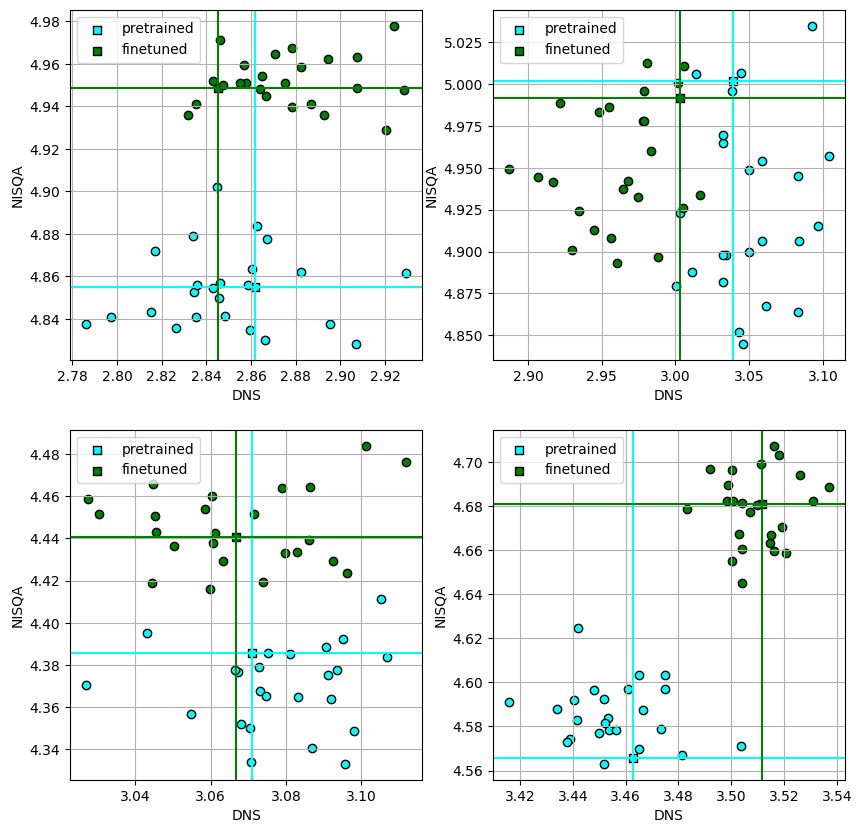

In [98]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
for i in range(4):
    scores = np.concatenate([DMOS_PRE[i], NMOS_PRE[i]], axis=-1)
    ax[i].scatter(scores[0, 0], scores[0, 1], color='cyan', marker=',', edgecolor='black', label='pretrained')
    ax[i].scatter(scores[1:, 0], scores[1:, 1], color='cyan', edgecolor='black')
    ax[i].axvline(x=scores[0, 0], color='cyan')
    ax[i].axhline(y=scores[0, 1], color='cyan')
    
    scores = np.concatenate([DMOS_RL[i], NMOS_RL[i]], axis=-1)
    ax[i].scatter(scores[0, 0], scores[0, 1], color='green', marker=',', edgecolor='black', label='finetuned')
    ax[i].scatter(scores[1:, 0], scores[1:, 1], color='green', edgecolor='black')
    ax[i].axvline(x=scores[0, 0], color='green')
    ax[i].axhline(y=scores[0, 1], color='green')
    
    ax[i].grid()
    ax[i].legend(loc='upper left')
    ax[i].set_xlabel('DNS')
    ax[i].set_ylabel('NISQA')
